<div align="center">
    <h1><b>Εργασία Ενισχυτικής Μηχανικής Μάθησης</b></h1>
</div>

## **Εισαγωγικά**
Αυτό το notebook αποτελεί κομμάτι μιας εργασίας στο μάθημα **'Ενισχυτική Μηχανική Μάθηση & Στοχαστικά Παίγνια'** του τμήματος **[Πληροφορικής και Τηλεπικοινωνιών](https://www.di.uoa.gr/)** του **Ε.Κ.Π.Α.**

### **Σκοπός**
Σκοπός της εργασίας είναι **πειραματιστούμε** με διάφορους **αλγορίθμους μηχανικής μάθησης**, έτσι ώστε να εκπαιδεύσουμε ένα μοντέλο πάνω σε ένα συγκεκριμένο **περιβάλλον** του **[Open-AI Gym ή Gymnasium](https://www.gymlibrary.dev/index.html)**

### **Μέλη Εργασίας**
Τα μέλη που αποτελούν αυτήν την εργασία είναι τα ακόλουθα:

| Όνομα | Επώνυμο | Α.Μ. | Email |
| :---: | :---: | :---: | :---: |
| Αντώνης | Ζήκας | 1115202100038 | sdi2100038@di.uoa.gr |
| Παναγιώτης | Παπαποστόλου | 1115202100142 | sdi2100142@di.uoa.gr |


## **Επιλογή και Ανάλυση Περιβάλλοντος**
Σε αυτήν την εργασία επιλέξαμε να ασχοληθούμε με το περιβάλλον **[CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)** το οποίο ανήκει στην κατηγορία **[Clasic Control](https://www.gymlibrary.dev/environments/classic_control/)**. 

<div align="center">
<img src="../assets/imgs/cart-pole-diagram.png" width="500px">    
</div>

Ας αναλύσουμε αυτό το περιβάλλον.

### **Action Space**:
Για το συγκεκριμένο περιβάλλον υπάρχουν **δύο ενέργειες** (actions) που μπορούν να γίνουν. Συγκεκριμένα το **καροτσάκι** (cart) μπορεί να μετακινηθεί είτε **αριστερά** είτε **δεξιά**. Οι ενέργειες αυτές αναπαρίστανται με **0** και **1** αντίστοιχα και περιγράφονται στον παρακάτω πίνακα:

| Number | Action |
| :---: | :---: |
| 0 | Μετακίνηση προς τα αριστερά |
| 1 | Μετακίνηση προς τα δεξιά |

Επομένως το **action** του συγκεκριμένου περιβάλλοντος είναι ένα `ndarray` διαστάσεων `(1,)` και μπορεί να πάρει δύο τιμές `{1, 0}`.

### **Observation Space**:
Το **observation space** για το συγκεκριμένο περιβάλλον είναι μία συλλογή από **4** τιμές.
1. Την **θέση** του καροτσιού **(Cart Position)**
2. Την **ταχύτητα** του καροτσιού **(Cart Velocity)**
3. Την **γωνία** που σχηματίζει το κοντάρι με τον κάθετο άξονα **(Pole Angle)**
4. την **ταχύτητα** του κονταριού καθώς πέφτει **(Pole Angular Velocity)**

Αυτές οι τιμές αποθηκέυονται μέσα σε ένα `ndarray` διαστάσεων `(4,)` και κάθε τιμή έχει ορισμένα συγκεκριμένα όρια τα οποία περιγράφονται παρακάτω:

| Array index | Observation | Min Value | Max Value |
| :---: | :---: | :---: | :---: |
| 0 | Cart Position | $-4.8$ | $4.8$ |
| 1 | Cart Velocity | $-\infty$ | $+\infty$ |
| 2 | Pole Angle | ~ $0.418$ rad (-$24^{\circ}$) | ~ $0.418$ rad ($24^{\circ}$) |
| 3 | Pole Angular Velocity | $-\infty$ | $+\infty$ |


### **Reward**:
Για κάθε βήμα στην εκπαίδευση του μοντέλου η **αμοιβή** (reward) που λαμβάνει ο επιλεγμένος **πράκτορας** (agent) είναι `+1` συμπεριλαμβανομένου και του **βήματος τερματισμού**. Το **κατώφλι** (threshold) των αμοιβών στο συγκεκριμένο περιβάλλον είναι **475**.

## **Φόρτωση Περιβάλλοντος στην Python**

In [43]:
import gymnasium as gym

env = gym.make('CartPole-v1')
observations = env.observation_space.shape[0]
actions = env.action_space.n

print(f"Observations: {observations}, Actions: {actions}")
env.close()

Observations: 4, Actions: 2


Όπως παρατηρούμε από την παραπάνω εκτέλεση του κώδικα, τα **observations** και τα **actions** είναι πράγματι **4** και **2** αντίστοιχα. Ας επιχειρήσουμε να τρέξουμε αυτό το περιβάλλον **χωρίς** κάποιο εκπαιδευμένο μοντέλο και ας παρατηρήσουμε τα αποτελέσματα.

In [44]:
epochs = 200
epochs_scores = []

env = gym.make('CartPole-v1')
for epoch in range(1, epochs+1):
    env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample() # Chose a random action from 0 and 1
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        if terminated or truncated:
            observation, _ = env.reset()
            done = True
    
    epochs_scores.append(score)

env.close()

Ας οπτικοποιήσουμε το συνολικό **score** που έπιασε το περιβάλλον μας για κάθε **εποχή** (epoch).

<Figure size 640x480 with 0 Axes>

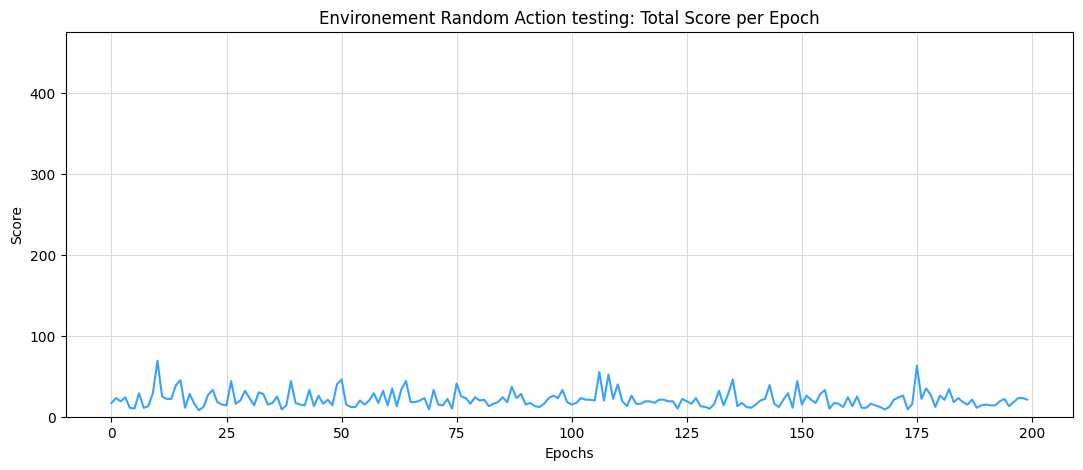

In [45]:
from matplotlib import pyplot as plt

plt.figure()
plt.figure(figsize=(13, 5))
plt.plot(epochs_scores, color='#37A2FF')
plt.ylim(0, 475)
plt.title("Environement Random Action testing: Total Score per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.grid(color='#DADADA')
plt.show()

Από το παραπάνω διάγραμμα παρατηρούμε πως το συνολικό **score** που πιάνει το περιβάλλον είναι πολύ χαμηλό. Στόχος μας λοιπόν είναι να **εκπαιδεύσουμε** ένα μοντέλο, έτσι ώστε να καταφέρουμε να αυξήσουμε το **score** μέχρι και το αντίστοιχο **threashold** του περιβάλλοντος, το οποίο είναι **475**.

## **Υλοποίηση του αλγορίθμου DQN (Deep Q-Network)**
Θα ξεκινήσουμε υλοποιώντας αλγόριθμο **[DQN](https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae)** ο οποίος θα χρησιμοποιηθεί για την εκπαίδευση του μοντέλου μας. Ο αλγόριθμος αυτός απαιτεί τη χρήση ενός **νευρωνικού δικτύου** (neural network) όπου για την κατασκευή του θα χρησιμοποιήσουμε το πακέτο **[PyTorch](https://pytorch.org/)**.

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:2400/format:webp/1*aqNgmfyBIStLrf9k7d9cng.jpeg" width="500px">
</div>

### **Κατασκευή Νευρωνικού Δικτύου**
Ας αρχίσουμε με τη κατασκευή του **νευρωνικού δικτύου**. Η **αρχιτεκτονική** του δικτύου θα είναι η ακόλουθη:
1. **Input Layer** with **4 nodes** (number of observations)
2. **Hidden Layer 1** with **24 nodes**
3. **Hidden Layer 2** with **24 nodes**
4. **Ouput Layer** with **2 nodes** (number of actions)

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, observation):
        x = F.relu(self.fc1(observation))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


### Σύνδεση με συσκευή CPU ή GPU
Θα φροντίσουμε επίσης το νευρωνικό μας δίκτυο να τρέξει σε συσκευή **GPU** (εάν αυτό προφανώς το επιτρέπει το μηχάνημα στο οποίο βρισκόμαστε) για **καλύτερη αποδοτικότητα**. Γι' αυτο το λόγο θα συνδέσουμε το pytorch σε συσκευή **CUDA** εάν είναι διαθέσιμη αλλιώς σε **CPU**.

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Pytorch connected to {device}')

Pytorch connected to cuda


### Κατασκευή Replay Buffer
Στη συνέχεια θα κατασκευάσουμε τη δομή του **ReplayBuffer**, η οποία θα λειτουργεί ως **μνήμη** στην εκπαίδευση του μοντέλου. 

In [48]:
import numpy as np
from collections import deque

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(device),
            torch.tensor(np.array(actions), dtype=torch.long).to(device),
            torch.tensor(np.array(rewards), dtype=torch.float32).to(device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
            torch.tensor(np.array(dones), dtype=torch.float32).to(device),
        )

    def __len__(self):
        return len(self.buffer)

### Ορισμός Υπερπαραμέτρων (Hyperparameters)
Για την εκπαίδευση του μοντέλου μας χρειαζόμαστε ορισμένες **υπερπαραμέτρους** που θα επηρεάσουν την **εκπαίδευση** του νευρωνικού δικτύου. Μερικές από αυτές τις παραμέτρους είναι το $\gamma$, το $\epsilon$, το **learning rate** κλπ.

In [49]:
# Hyperparameters
GAMMA = 0.99          # Discount factor
LR = 1e-3             # Learning rate
BATCH_SIZE = 64       # Minibatch size
MEMORY_SIZE = 10000   # Replay buffer size
EPSILON_START = 1.0   # Starting exploration probability
EPSILON_END = 0.01    # Minimum exploration probability
EPSILON_DECAY = 0.995 # Epsilon decay rate
TARGET_UPDATE = 10    # How often to update the target network

### Δημιουργία Νευρωνικών Δικτύων
Στη συνέχεια θα ορίσουμε δύο νευρωνικά δίκτυα όπου το ένα θα παίζει το ρόλο της **πολιτικής** που θα χρησιμοποιήσουμε στη διαδικασία εκπαίδευσης, και το άλλο θα παίζει το ρόλο του **στόχου**.

In [50]:
# Initialize networks, optimizer, and replay buffer
policy_net = DQN(observations, actions).to(device)
target_net = DQN(observations, actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

### Δημιουργία του Optimizer και του Replay Buffer
Θα δημιουργήσουμε επίσης τον **optimizer** που θα χρησιμοποιήσουμε στην εκπαίδευση του μοντέλου και το **replay buffer** που θα παίζει το ρόλο της μνήμης. Για τον optimizer θα χρησιμοποιήσουμε τον **Adam**.

In [51]:
import torch.optim as optim

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(MEMORY_SIZE)

### Ορισμός πολιτικής E-Greedy
Θα πρέπει επίσης να ορίσουμε την $\epsilon$ greedy πολιτική του αλγορίθμου μας που θα χρησιμοποιεί τις **υπερπαραμέτρους** που ορίσαμε παραπάνω για το $\epsilon$. Με αυτόν τον τρόπο κάθε φορά θα επιλέγεται μία **ενέργεια** του περιβάλλοντος είτε **τυχαία** είτε μέσω του **νευρωνικού** που ορίσαμε.

In [52]:
# Epsilon-greedy policy
def select_action(state):
    global epsilon
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            return policy_net(state).argmax(dim=1).item()  # Exploit

### Διαδικασία Εκπαίδευσης
Ήρθε λοιπόν η ώρα να ορίσουμε τη διαδικασία εκπαίδευσης του μοντέλου μας.

In [53]:
import random

total_rewards = []
max_reward = -1
epsilon = EPSILON_START

# Training loop
def train_model(epochs):
    global epsilon
    global max_reward
    
    for episode in range(epochs):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Select action
            action = select_action(state)

            # Step in the environment
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state

            # Sample from replay buffer and train
            if len(replay_buffer) > BATCH_SIZE:
                states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = (
                    states.to(device), actions.to(device), rewards.to(device),
                    next_states.to(device), dones.to(device)
                )

                # Compute Q-values and target Q-values
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(dim=1)[0]
                    target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

                # Compute loss and optimize
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update epsilon
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        # Update target network
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        total_rewards.append(total_reward)
        if (total_reward > max_reward):
            max_reward = total_reward
            torch.save(policy_net.state_dict(), "best_network.pth")

        print(f"Episode {episode}, Total Reward: {total_reward}")


### Εκπαίδευση Μοντέλου
Ας δοκιμάσουμε τη μέθοδό μας εκπαιδεύοντας ένα μοντέλο για το συγκεκριμένο περιβάλλον.

In [54]:
env = gym.make('CartPole-v1')
train_model(200)
env.close()

Episode 0, Total Reward: 16.0
Episode 1, Total Reward: 36.0
Episode 2, Total Reward: 21.0
Episode 3, Total Reward: 14.0
Episode 4, Total Reward: 38.0
Episode 5, Total Reward: 26.0
Episode 6, Total Reward: 31.0
Episode 7, Total Reward: 18.0
Episode 8, Total Reward: 15.0
Episode 9, Total Reward: 17.0
Episode 10, Total Reward: 17.0
Episode 11, Total Reward: 12.0
Episode 12, Total Reward: 11.0
Episode 13, Total Reward: 13.0
Episode 14, Total Reward: 20.0
Episode 15, Total Reward: 24.0
Episode 16, Total Reward: 21.0
Episode 17, Total Reward: 9.0
Episode 18, Total Reward: 16.0
Episode 19, Total Reward: 11.0
Episode 20, Total Reward: 23.0
Episode 21, Total Reward: 22.0
Episode 22, Total Reward: 18.0
Episode 23, Total Reward: 12.0
Episode 24, Total Reward: 59.0
Episode 25, Total Reward: 39.0
Episode 26, Total Reward: 37.0
Episode 27, Total Reward: 11.0
Episode 28, Total Reward: 21.0
Episode 29, Total Reward: 17.0
Episode 30, Total Reward: 19.0
Episode 31, Total Reward: 23.0
Episode 32, Total R

Ας δούμε τα αποτελέσματα της εκπαίδευσης.

<Figure size 640x480 with 0 Axes>

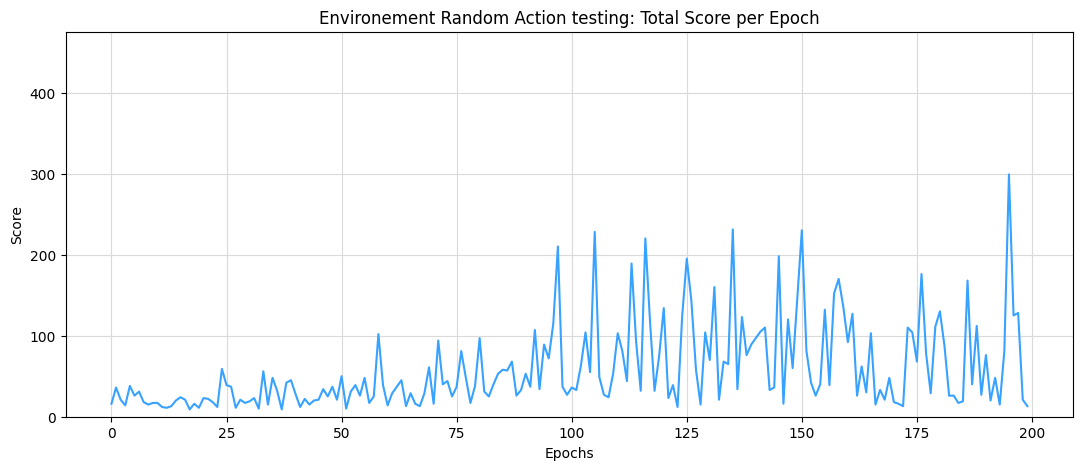

In [55]:
from matplotlib import pyplot as plt

plt.figure()
plt.figure(figsize=(13, 5))
plt.plot(total_rewards, color='#37A2FF')
plt.ylim(0, max(475, max(total_rewards)))
plt.title("Environement Random Action testing: Total Score per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.grid(color='#DADADA')
plt.show()

In [56]:
print(max(total_rewards))

299.0


In [57]:
import torch
import gymnasium as gym

def test_agent(env, policy_net, num_episodes=10, render=True):
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            if render:
                env.render()

            # Convert state to tensor and get action from policy network
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax(dim=1).item()  # Choose action with highest Q-value

            # Take the action in the environment
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            state = next_state

        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    env.close()
    
env = gym.make('CartPole-v1')

observations = env.observation_space.shape[0]
actions = env.action_space.n

# Call the test function
policy_net = DQN(observations, actions).to(device)
policy_net.load_state_dict(torch.load('./best_network.pth'))
policy_net.eval()

test_agent(env, policy_net, num_episodes=10)


Episode 1: Total Reward = 173.0
Episode 2: Total Reward = 228.0
Episode 3: Total Reward = 192.0
Episode 4: Total Reward = 104.0
Episode 5: Total Reward = 213.0
Episode 6: Total Reward = 168.0
Episode 7: Total Reward = 112.0
Episode 8: Total Reward = 257.0
Episode 9: Total Reward = 114.0
Episode 10: Total Reward = 103.0
